# More on working with SRTM data.

## License

```
Further information about working with SRTM data.
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import pycraf
from pycraf import pathprof as pp
from tempfile import mkdtemp

assert pycraf.__version__ >= '0.25.2', (
    'This notebook needs at least version 0.25.2 to run.'
    )

## Obtaining SRTM data

With pycraf it is very easy to work with SRTM data to generate height profiles and terrain maps. How SRTM data can be obtained is described in detail in the [documentation](https://bwinkel.github.io/pycraf/pathprof/working_with_srtm.html). However, here we are going to show a couple of the possibilities. There are two different approaches:

1. Download SRTM data manually, place them in a directory of your choice and either start the Python interpreter in that
  directory or define an environment variable `SRTMDATA` to point to that directory.
2. Work with the `SrtmConf` manager to change the directory during run-time.

The second approach also allows to download missing tiles on the fly. In this tutorial, we'll look into this in more detail.

## Using the `SrtmConf` manager
### Changing the SRTM directory

The `SrtmConf` manager can either used to modify pycraf's configuration (with respect to SRTM handling). For the remaining tutorial let's assume that no SRTM tile data has been downloaded already. To avoid producing clutter, we use a temporary directory for the data:

In [3]:
temp_srtm_dir = mkdtemp()

In [4]:
# set SRTM directory
pp.SrtmConf.set(srtm_dir=temp_srtm_dir)

<MultiState SrtmConf>

The `SrtmConf` manager has various attributes (aka configuration options), which the user can change:

In [19]:
print(pp.SrtmConf._attributes)

('srtm_dir', 'download', 'server', 'interp', 'spline_opts', 'tile_size', 'hgt_res')


With the above statement, we had already assigned a new directory. All options stay valid for the full Python session. However, sometimes one only wants to temporarily change a config. This can be done, by using `SrtmConf` as context manager:

In [20]:
with pp.SrtmConf.set(srtm_dir='.'):
    print('Directory within context manager: "{}"'.format(pp.SrtmConf.srtm_dir))

Directory within context manager: "."


Afterwards, the `srtm_dir` attribute will again point to the temporary directory created in the beginning.

### Download missing tiles

By default, pycraf won't download missing SRTM data:

In [21]:
# define geographic longitudes and latitudes to query data for
# we make use of numpy's broadcasting rules
bbox = (7.55, 7.65, 45.95, 46.05)
lons = np.linspace(bbox[0], bbox[1], 501) * u.deg
lats = np.linspace(bbox[2], bbox[3], 501)[:, np.newaxis] * u.deg

try:
    heights = pp.srtm_height_data(lons, lats)
except OSError as e:
    # avoid printing full traceback
    print(e.args[0].split('\n')[0])

It is possible, to have pycraf download missing tiles:

In [22]:
with pp.SrtmConf.set(download='missing'):
    heights = pp.srtm_height_data(lons, lats)

Because one usually queries height data for coordinates other than the original SRTM grid, pycraf applies interpolation.
It is noteworthy that the tile data interpolators are cached in memory to improve computing speed for the remaining session. In total up to 32 tiles are kept in RAM. If you want to clear the cache, do:

In [9]:
# info on cache hits is also available
# print(pp.srtm.get_tile_interpolator.cache_info())

# clear cache, if you want
# pp.srtm.get_tile_interpolator.cache_clear()

By default, bi-linear interpolation is applied. There is also nearest-neighbor and spline interpolation available:

In [23]:
# since above we downloaded the missing tile already,
# we don't need the 'download' option below anymore
with pp.SrtmConf.set(interp='linear'):
    # technically, one could omit the context in this case
    # as 'linear' is the default
    heights_linear = pp.srtm_height_data(lons, lats)
    
with pp.SrtmConf.set(interp='nearest'):
    heights_nn = pp.srtm_height_data(lons, lats)
    
with pp.SrtmConf.set(interp='spline'):
    heights_spline = pp.srtm_height_data(lons, lats)
    

Let's plot the difference

In [24]:
imkwargs = dict(
    interpolation='nearest',  # this is important to avoid mpl interpolation
    origin='lower', cmap='viridis',
    extent=bbox, vmin=1900, vmax=3900
    )

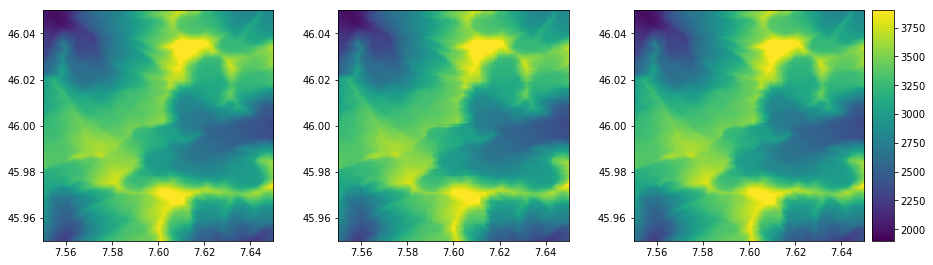

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9)
cax = fig.add_axes((0.9, 0.1, 0.02, 0.8))
im = axes[0].imshow(heights_linear.to(u.m).value, **imkwargs)
axes[1].imshow(heights_nn.to(u.m).value, **imkwargs)
axes[2].imshow(heights_spline.to(u.m).value, **imkwargs)
cbar = plt.colorbar(im, cax=cax)

As can be seen, the differences are barely visible even after zooming-in quite a bit. However, there are artefacts in the data. For problematic regions (e.g., the Alps), one could have a look at the tiles provided by [viewfinderpanoramas.org](http://www.viewfinderpanoramas.org). These are not official, but have been post-processed to fill holes, etc.

To use them, we first have to clear the interpolator cache and then delete the old tile data in our temporary directory.

In [16]:
pp.srtm.get_tile_interpolator.cache_clear()
shutil.rmtree(temp_srtm_dir)
os.mkdir(temp_srtm_dir)

In [17]:
with pp.SrtmConf.set(interp='linear', download='missing', server='viewpano'):
    # technically, one could omit the context in this case
    # as 'linear' is the default
    heights_linear_vp = pp.srtm_height_data(lons, lats)
    
# since above we downloaded the missing tile already,
# we don't need the 'download' option below anymore
with pp.SrtmConf.set(interp='nearest'):
    heights_nn_vp = pp.srtm_height_data(lons, lats)
    
with pp.SrtmConf.set(interp='spline'):
    heights_spline_vp = pp.srtm_height_data(lons, lats)
    

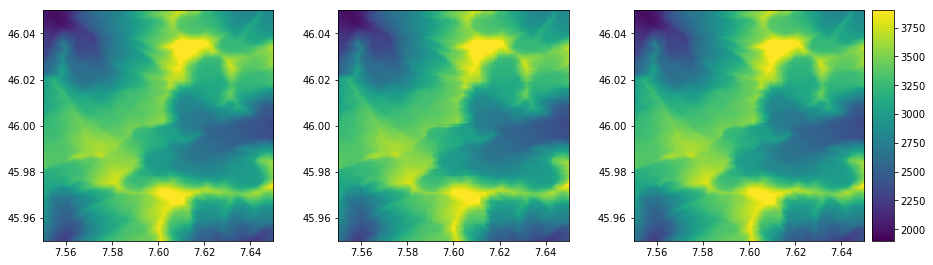

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9)
cax = fig.add_axes((0.9, 0.1, 0.02, 0.8))
im = axes[0].imshow(heights_linear_vp.to(u.m).value, **imkwargs)
axes[1].imshow(heights_nn_vp.to(u.m).value, **imkwargs)
axes[2].imshow(heights_spline_vp.to(u.m).value, **imkwargs)
cbar = plt.colorbar(im, cax=cax)

Let's finish by cleaning up the temporary directory:

In [16]:
shutil.rmtree(temp_srtm_dir)

A final comment on the `pathprof.srtm_height_profile` and `pathprof.srtm_height_map` functions: for very long paths/large maps one might choose a spatial resolution that is worse than the original 3-arcsecond (90-m) resolution of the SRTM data. To avoid aliasing (i.e., skipping over important terrain features such as individual hill/mountain summits), pycraf downsamples the terrain data in such cases, by applying a Gaussian filter to the high-resolution data first. This will, of course, also have some impact on the results, but less than in the case of simply omitting values.